In [1]:
import torch
import torchfcn
import torchvision
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import fcn

/Users/rama/src/research/code/pytorch-fcn-2/.pyt-venv/lib/python3.7/site-packages/chainer/_environment_check.py:41: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  ''')  # NOQA


#### Understand the datasets for training and cross-validation¶

In [2]:
# Assume the datasets are downloaded to the loc. below
root = osp.expanduser('~/data/datasets')

In [3]:
def imshow(img):
    plt.imshow(img)
    plt.show()
    
def hist(img):
    plt.hist(img)
    plt.show()

#### Dataset for the cityscapes dataset

In [4]:

# Note: we set the transform to False, this ensures that the result of __get_item is an 
# ndarray, not a tensor.
train_dataset = torchfcn.datasets.CityScape(root, split='train', transform=False)
print(train_dataset)
print(f"Number of entries in the training: {len(train_dataset)}")

Number of entries in the training: 17850


Shape of image:  (256, 512, 3) shape of the label:  (256, 512)


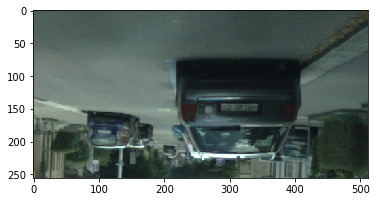

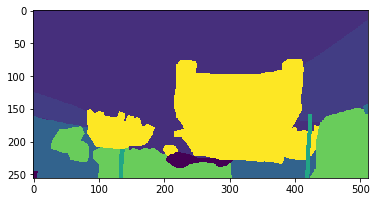

In [5]:
idx = 500

print("Shape of image: ", train_dataset[idx][0].shape, "shape of the label: ", train_dataset[idx][1].shape)
imshow(train_dataset[idx][0])
imshow(train_dataset[idx][1])
# print(train_dataset[idx][1])

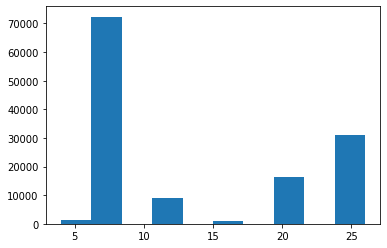

In [6]:
idx = 500
label_dist = np.ravel(train_dataset[idx][1])
hist(label_dist)

#### Ensure that a transformed tensor loads

torch.Size([3, 256, 512])
tensor(4)
Max 26 Min 4


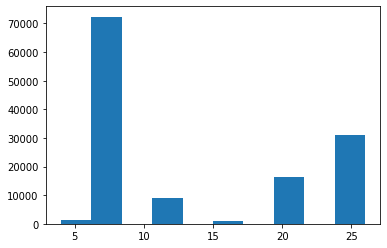

In [7]:
## Let us actually inspect the transformed tensor data instead
valid_tensor_dataset = torchfcn.datasets.CityScape(root, split='train', transform=True)

print(valid_tensor_dataset[idx][0].shape)
label_dists = valid_tensor_dataset[idx][1]
print(torch.min(label_dists))

label_dist = np.ravel(label_dists.numpy())
print("Max", np.max(label_dist), "Min", np.min(label_dist))
hist(label_dist)

#### Lets checkout the validation set

In [8]:
# Note: we set the transform to False, this ensures that the result of __get_item is an 
# ndarray, not a tensor.
val_dataset = torchfcn.datasets.CityScape(root, split='val', transform=False)
print(val_dataset)
print(f"Number of entries in the training: {len(val_dataset)}")

Number of entries in the training: 500


Shape of image:  (256, 512, 3) shape of the label:  (256, 512)


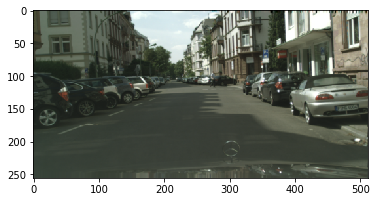

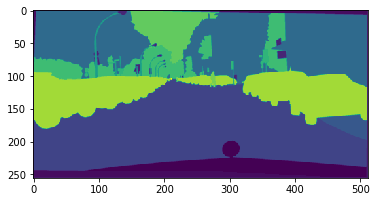

In [9]:
idx = 459
print("Shape of image: ", val_dataset[idx][0].shape, "shape of the label: ", val_dataset[idx][1].shape)
imshow(val_dataset[idx][0])
imshow(val_dataset[idx][1])
# print(train_dataset[idx][1])

#### Inspect the dataset transformed?

In [10]:
mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])

def transform(img):
    #img = img[:, :, ::-1]  # RGB -> BGR
    img = img.astype(np.float64)
    img -= mean_bgr
    return img

In [11]:
print(val_dataset[idx][0].shape)
transformed_image = transform(val_dataset[idx][0])
print(transformed_image.shape)

(256, 512, 3)
(256, 512, 3)


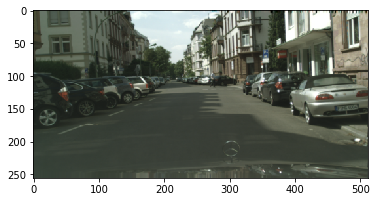

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


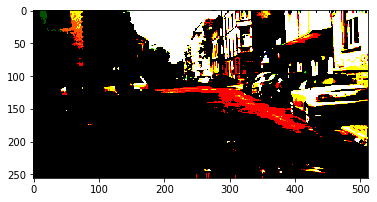

In [12]:
imshow(val_dataset[idx][0])
imshow(transformed_image)

In [13]:
## Lets work with a dataloader
train_loader = torch.utils.data.DataLoader(
    torchfcn.datasets.CityScape(root, split='train', transform=True),
    batch_size=1, shuffle=True)
print(train_loader)
print(train_loader.dataset.class_names)

['ego vehicle' 'rectification border' 'out of roi' 'static' 'dynamic'
 'ground' 'road' 'sidewalk' 'parking' 'rail track' 'building' 'wall'
 'fence' 'guard rail' 'bridge' 'tunnel' 'pole' 'polegroup' 'traffic light'
 'traffic sign' 'vegetation' 'terrain' 'sky' 'person' 'rider' 'car'
 'truck' 'bus' 'caravan' 'trailer' 'train' 'motorcycle' 'bicycle'
 'license plate']


In [14]:
## Let us actually inspect the transformed tensor data instead
test_tensor_dataset = torchfcn.datasets.CityScape(root, split='train', transform=True)
print(test_tensor_dataset[idx][0].shape)
print(test_tensor_dataset[idx][1].shape)

torch.Size([3, 256, 512])
torch.Size([256, 512])


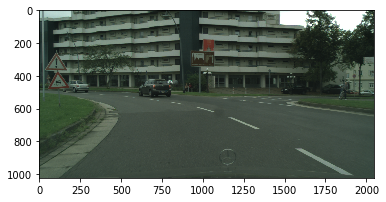

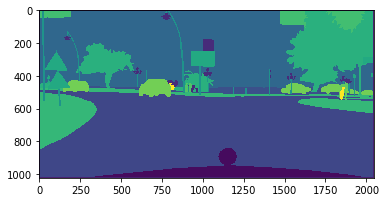

In [15]:
import PIL.Image
image_path = osp.expanduser("~/data/datasets/CityScapes/CityScapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png")
label_path = osp.expanduser("~/data/datasets/CityScapes/CityScapes/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png")
img = PIL.Image.open(image_path)
imshow(img)

lbl = PIL.Image.open(label_path)
imshow(lbl)


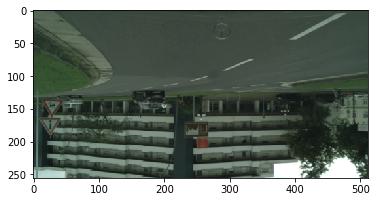

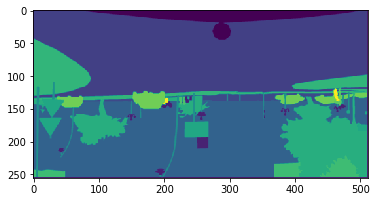

In [16]:
# Center crop
from torchfcn.datasets.transforms import apply_transform, ImageTransformType, FlipType

new_image, new_lbl = apply_transform(img, lbl, ImageTransformType.Resize, FlipType.Vertical,  256, 512)

imshow(new_image)
imshow(new_lbl)

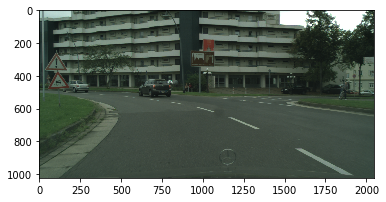

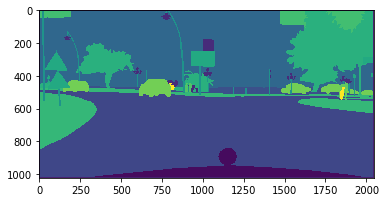

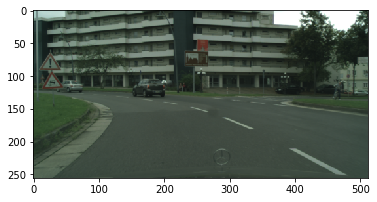

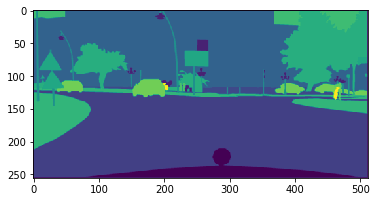

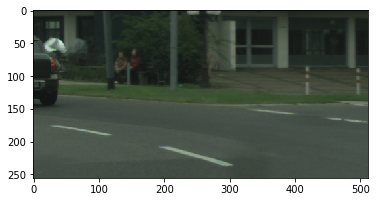

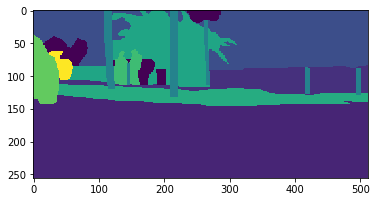

In [17]:
import PIL.Image
image_path = osp.expanduser("~/data/datasets/CityScapes/CityScapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png")
label_path = osp.expanduser("~/data/datasets/CityScapes/CityScapes/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png")
img = PIL.Image.open(image_path)
imshow(img)

lbl = PIL.Image.open(label_path)
imshow(lbl)

resized_image = torchvision.transforms.Resize([256, 512])(img)
imshow(resized_image)
resized_lbl = torchvision.transforms.Resize([256, 512])(lbl)
imshow(resized_lbl)

cropped_image = torchvision.transforms.CenterCrop([256, 512])(img)
imshow(cropped_image)
cropped_lbl = torchvision.transforms.CenterCrop([256, 512])(lbl)
imshow(cropped_lbl)




0



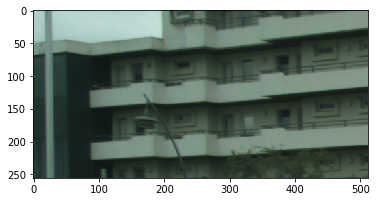

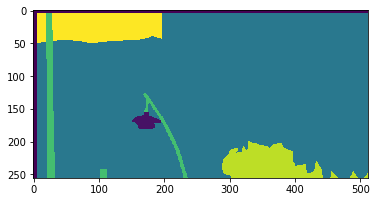

1



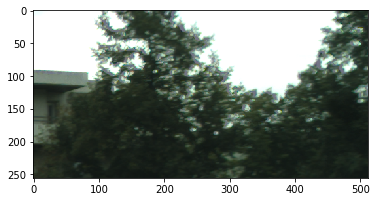

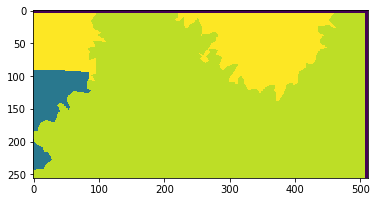

2



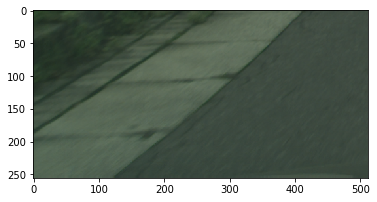

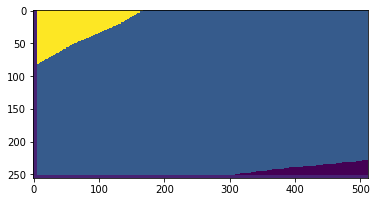

3



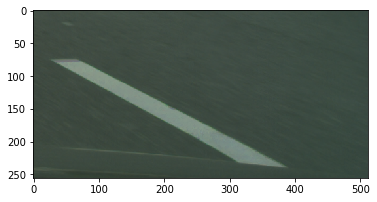

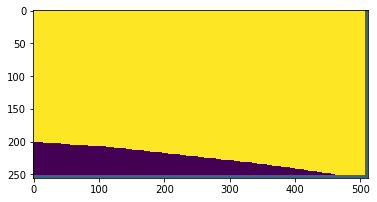

4



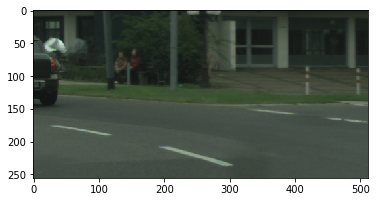

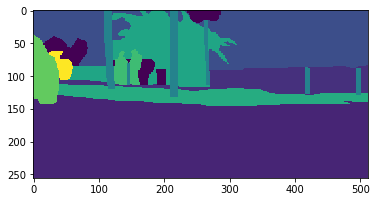

5



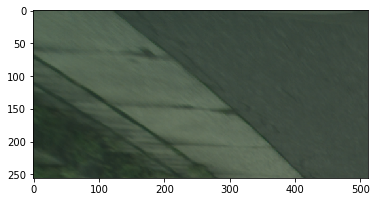

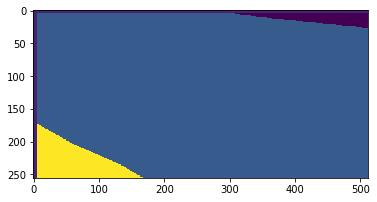

6



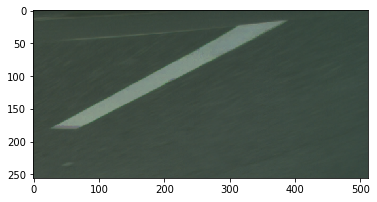

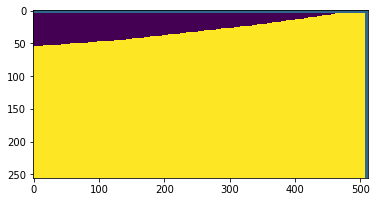

7



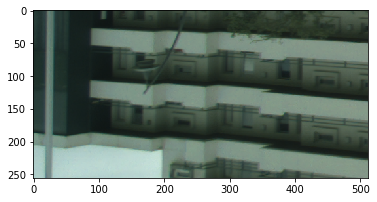

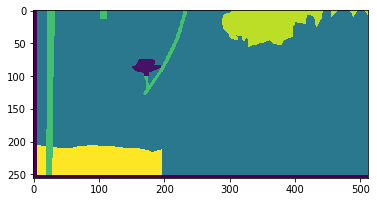

8



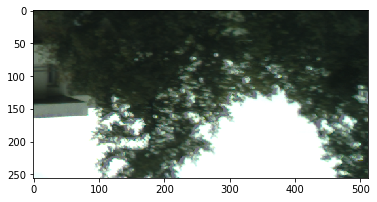

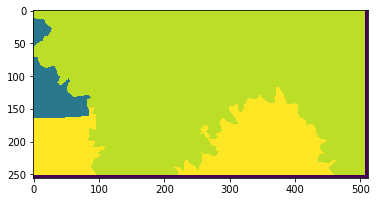

9



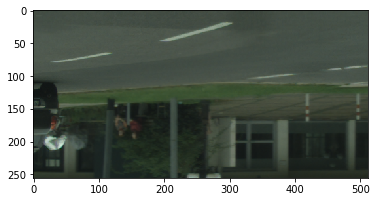

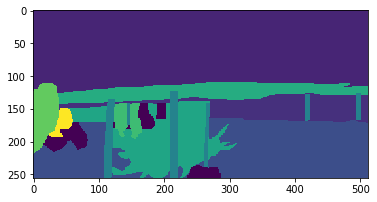

In [18]:
entries_img = torchvision.transforms.TenCrop([256, 512], vertical_flip=True)(img)
entries_lbl = torchvision.transforms.TenCrop([256, 512], vertical_flip=True)(lbl)
for i in range(len(entries_img)):
    print(f"{i}\n")
    imshow(entries_img[i])
    imshow(entries_lbl[i])